# Benchmarks

In this notebook, we show timings of different parts of **seismiQB**: data generation, segmentation mask creation, model training. We perform each of them in multiple ways, showing different approaches and interfaces provided by our framework (and by **BatchFlow**).

Note that this is advanced notebook that requires you to read our other [tutorials and notebooks](./Carcass%20interpolation/01_M_cube.ipynb) to understand what is going on: we don't pay too much time explaining what exactly cells are doing and what is achieved by their code, we merely time it.

* [Data loading](data)
* [Model architecture](architecture)
* [Pipelines: loading, augmentation and training](pipelines)
* [Load + augmentation profile](profile1)
* [Model training profile](profile2)
* [Inference profile](inference)
* [Conclusion](conclusion)

In [1]:
# Necessary imports
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 2000)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from pytorch_lightning import LightningModule, Trainer

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, F, D, P, R, W
from seismiqb.batchflow.batchflow.models.torch import EncoderDecoder, ResBlock # Note the import!

from seismiqb import SeismicCubeset, Horizon, plot_image

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# Global parameters
FREQUENCIES = [50]               # carcass frequency at `hard` and `easy` locations
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops
ITERS = 100                      # number of train iterations
BATCH_SIZE = 64                  # number of crops inside one batch

<a id='data'></a>
# Load everything

First of all, we load dataset with seismic cube and a horizon. This operation is performed once per dataset and does not take more that one minute even for all of our cubes (10 total) and horizons (50+ total).

In [3]:
%%time
cube_path = '/data/seismic/CUBE_2/M_cube.hdf5'
horizon_path = '/data/seismic/CUBE_2/RAW/t0_B_anon'

dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries()
dataset.create_labels({dataset.indices[0]: [horizon_path]})

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

CPU times: user 2.24 s, sys: 277 ms, total: 2.51 s
Wall time: 2.63 s


In [4]:
# Create carcass to train on
quality_grid = geometry.make_quality_grid(FREQUENCIES)
grid_coverage = (np.nansum(geometry.quality_grid) /
                 (np.prod(geometry.cube_shape[:2]) - np.nansum(geometry.zero_traces)))

# Create sampler, according to carcass
dataset.create_sampler(quality_grid=True)
dataset.modify_sampler('train_sampler', finish=True)

<a id='architecture'></a>
# Model architecture

In [5]:
class Dice(nn.Module):
    def forward(self, input, target):
        input = torch.sigmoid(input)
        dice_coeff = 2. * (input * target).sum() / (input.sum() + target.sum() + 1e-7)
        return 1 - dice_coeff


MODEL_CONFIG = {
    # Defining input shapes here allows to build model at initialization
    'inputs': {
        'images/shape': CROP_SHAPE,
        'masks/shape': CROP_SHAPE,
    },
    
    # Model layout
    'initial_block': {
        'inputs': 'images',
        'base_block': ResBlock,
        'filters': 16,
        'kernel_size': 5,
        'downsample': False,
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [16, 32, 64, 128],
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 256,
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'bna',
            'scale_factor': 2,
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32, 16],
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': Dice(),
    'optimizer': {'name': 'Adam', 'lr': 0.01,},
    "decay": {'name': 'exp', 'gamma': 0.1},
    "n_iters": 150,
    'microbatch': 4,
    'common/activation': 'relu6',
}

The first call to a GPU takes some time in order to initialize CUDA states; to eliminate this time from actual model initialization time, we manually put some data to the GPU of choice:

In [6]:
np_tensor = np.random.random((10,)).astype(np.float32)

tensor = torch.from_numpy(np_tensor)
%time tensor = tensor.cuda()

tensor = torch.from_numpy(np_tensor)
%time tensor = tensor.cuda()

CPU times: user 4.49 s, sys: 2.03 s, total: 6.52 s
Wall time: 54.3 s
CPU times: user 1.5 ms, sys: 238 µs, total: 1.74 ms
Wall time: 1.5 ms


This time we create instance of model directly, without `init_model` action of `Pipeline`:

In [7]:
%%time
model = EncoderDecoder(MODEL_CONFIG)

CPU times: user 325 ms, sys: 153 ms, total: 478 ms
Wall time: 6.73 s


<a id='pipelines'></a>
# All the pipelines

In [8]:
load_pipeline = (
    Pipeline()

    # Load data/masks
    .crop(points=D('train_sampler')(BATCH_SIZE),
          shape=CROP_SHAPE, adaptive_slices=True)
    .create_masks(dst='masks', width=5)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=CROP_SHAPE)
    .scale(mode='q', src='images')
) << dataset

In [9]:
aug_pipeline = (
    Pipeline()

    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .flip(axis=1, src=['images', 'masks'], seed=P(R('uniform', 0, 1)))
    .additive_noise(scale=0.005, src='images', dst='images')
    .rotate(angle=P(R('uniform', -15, 15)),
            src=['images', 'masks'])
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'])
    .elastic_transform(alpha=P(R('uniform', 35, 45)),
                       sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'])
    .transpose(src=['images', 'masks'], order=(2, 0, 1))
) << dataset

In [10]:
model_pipeline = (
    Pipeline()

    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .import_model(model, name='model')

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
) << dataset

<a id='profile1'></a>
# Data generation and augmentations profile

## Regular pipeline usage

That is how we usually use pipelines: simple `run` is enough

In [11]:
%%time
data_pipeline = load_pipeline + aug_pipeline
data_pipeline.run(D.size, n_iters=ITERS, bar=True)

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]

CPU times: user 53.4 s, sys: 443 ms, total: 53.8 s
Wall time: 53.8 s


One of the design decisions of our framework is that items in our datasets are cubes: in that notebook, there is only one cube in the `dataset`, therefore, `D.size` evaluates to 1. The logic of converting *batch of cubes* into *batch of crops* is conveniently resides inside `crop` action: under the hood the conversion is performed by creating entirely new batch with generated crop locations. That somewhat confusing behaviour, where one needs to pass *number of cubes* as the `batch size` in `Pipeline.run` method while setting the actual amount of crops elsewhere, allows us to threat tasks with one or multiple cubes the same: there is virtually no changes to do in order to move from the task of carcass interpolation (one cube) to the inter-cube generalization (multiple cubes, as can be deduced by the name).

Setting `profile` argument of `run` to `True` allows us to monitor timings of every individual action; it takes some time to parse and log the profiling results, thus giving (a lot of) overhead. Note that the more iteration you run with `profile` on, the slower it becomes.

In [12]:
%%time
data_pipeline = load_pipeline + aug_pipeline
data_pipeline.run(D.size, n_iters=ITERS, bar=True, profile=True)

100%|██████████| 100/100 [01:45<00:00,  1.06s/it]

CPU times: user 1min 45s, sys: 424 ms, total: 1min 45s
Wall time: 1min 45s


Method `show_profile_info` returns a formatted dataframe that can be further explored:

In [13]:
result = data_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result

Total time of actions running:  61.31506085395813


total_time                     pipeline_time            \
                             sum      mean       max           sum      mean   
action                                                                         
elastic_transform #10  16.591213  0.165912  0.206019     16.156625  0.161566   
rotate #8               8.150466  0.081505  0.105052      7.760077  0.077601   
additive_noise #7       8.096665  0.080967  0.112021      7.733453  0.077335   
scale_2d #9             7.526794  0.075268  0.100932      7.139538  0.071395   
flip #6                 6.864179  0.068642  0.088311      6.467513  0.064675   
load_cubes #2           3.940150  0.039402  0.053611      3.541042  0.035410   
crop #0                 2.007738  0.020077  0.028541      1.535607  0.015356   
create_masks #1         1.989823  0.019898  0.025676      1.643096  0.016431   
adaptive_reshape #3     1.750568  0.017506  0.030675      1.396318  0.013963   
transpose #5            1.587047  0.015870  0.020762      1.225269  0.012253   
transpose #11           1.549700  0.015497  0.019853      1.187448  0.011874   
scale #4                1.260717  0.012607  0.015651      0.923952  0.009240   

                                 
                            max  
action                           
elastic_transform #10  0.201630  
rotate #8              0.100220  
additive_noise #7      0.107465  
scale_2d #9            0.095964  
flip #6                0.083298  
load_cubes #2          0.048439  
crop #0                0.023295  
create_masks #1        0.021131  
adaptive_reshape #3    0.026086  
transpose #5           0.015687  
transpose #11          0.014007  
scale #4               0.011574

Each row in the dataframe corresponds to individual action: note that we have two `transpose` actions in our augmentation pipeline, thus multiple transposes appear in the table. `total_time` is time take by both action and pipeline inner workings; `pipeline_time` counts only the time of action running. Sub-columns `sum`, `mean` and `max` provide a more detailed description.

We can get a more detailed description of which exactly *lines of code* take the most time inside our actions by passing `detailed` argument to the `show_profile_info` method. To avoid cluttering in the notebook, we limit the output to two slowest calls per action:

In [14]:
data_pipeline.show_profile_info(detailed=True, limit=2)['tottime'][['sum']]

sum
action                id                                                          
adaptive_reshape #3   <built-in method numpy.core._multiarray_umath.i...  0.805385
                      _adaptive_reshape_::../seismiqb/batchflow/batch...  0.037436
additive_noise #7     <method 'standard_normal' of 'numpy.random.gene...  6.058748
                      _additive_noise_::../seismiqb/batchflow/batchfl...  0.432049
create_masks #1       add_to_mask::../seismiqb/src/crop_batch.py::299...  0.677045
                      <built-in method numpy.zeros>::../seismiqb/src/...  0.240521
crop #0               _correct_point_to_grid::../seismiqb/src/crop_ba...  0.208698
                      _correct_point_to_grid::../seismiqb/src/crop_ba...  0.144012
elastic_transform #10 <remap>::../seismiqb/src/crop_batch.py::866::_e...  6.113717
                      <resize>::../seismiqb/src/crop_batch.py::866::_...  1.337431
flip #6               <flip>::../seismiqb/src/crop_batch.py::787::_flip_  2.306319
                      _flip_::../seismiqb/batchflow/batchflow/batch.p...  1.118823
load_cubes #2         <listcomp>::../seismiqb/src/geometry.py::867::_...  1.144565
                      <listcomp>::../seismiqb/src/geometry.py::872::_...  0.341566
rotate #8             <warpAffine>::../seismiqb/src/crop_batch.py::77...  6.171653
                      <built-in method numpy.core._multiarray_umath.i...  0.669558
scale #4              <built-in method numpy.core._multiarray_umath.i...  0.340364
                      scaler::../seismiqb/src/crop_batch.py::458::scale   0.291098
scale_2d #9           <warpAffine>::../seismiqb/src/crop_batch.py::80...  5.563824
                      <built-in method numpy.core._multiarray_umath.i...  0.670749
transpose #11         <built-in method numpy.core._multiarray_umath.i...  0.670805
                      _apply_transform::../seismiqb/batchflow/batchfl...  0.032495
transpose #5          <built-in method numpy.core._multiarray_umath.i...  0.706892
                      _apply_transform::../seismiqb/batchflow/batchfl...  0.033203

We can also show individual timings for each iteration. That can be helpful to detect memory leaks and other cumulative errors:

In [15]:
data_pipeline.show_profile_info(per_iter=True).ix[:2]

total_time  pipeline_time         batch_id
iter action                                                           
1    elastic_transform #10    0.162503       0.158176  140624805624352
     additive_noise #7        0.078480       0.075140  140624805624352
     rotate #8                0.078305       0.074571  140624805624352
     scale_2d #9              0.073361       0.069629  140624805624352
     flip #6                  0.068833       0.065061  140624805624352
     load_cubes #2            0.040120       0.036306  140624805624352
     crop #0                  0.024513       0.018642  140624805624352
     create_masks #1          0.019764       0.016418  140624805624352
     transpose #5             0.017195       0.013703  140624805624352
     adaptive_reshape #3      0.016740       0.013422  140624805624352
     transpose #11            0.015218       0.011933  140624805624352
     scale #4                 0.014300       0.011159  140624805624352
2    elastic_transform #10    0.163077       0.158753  140624806816792
     additive_noise #7        0.080263       0.076890  140624806816792
     rotate #8                0.078320       0.074512  140624806816792
     scale_2d #9              0.073629       0.069793  140624806816792
     flip #6                  0.068007       0.064147  140624806816792
     load_cubes #2            0.039613       0.035757  140624806816792
     crop #0                  0.020211       0.016007  140624806816792
     create_masks #1          0.019059       0.015898  140624806816792
     transpose #5             0.017058       0.013565  140624806816792
     adaptive_reshape #3      0.016495       0.013044  140624806816792
     transpose #11            0.015206       0.011840  140624806816792
     scale #4                 0.014023       0.011006  140624806816792

Refer to [profiling tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/08_profiling.ipynb) to learn more about exact collected information and how to format it.

## Pipeline as data generator

`Pipeline` has multiple interfaces; `gen_batch` allows to iterate over batches, using their attributes with data as usual `NumPy` arrays:

In [16]:
%%time
data_pipeline = load_pipeline + aug_pipeline 

for batch in tqdm(data_pipeline.gen_batch(D.size, n_iters=ITERS), total=ITERS):
    images, masks = batch.images, batch.masks

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

CPU times: user 53.3 s, sys: 121 ms, total: 53.5 s
Wall time: 53.4 s


You can pass the `profile` argument to the `gen_batch` method. For now, let's just make sure that `images` and `masks` variables contain what we expect:

images: (<class 'numpy.ndarray'>, dtype('float32'), (64, 1, 256, 256))
masks:  (<class 'numpy.ndarray'>, dtype('float32'), (64, 1, 256, 256))


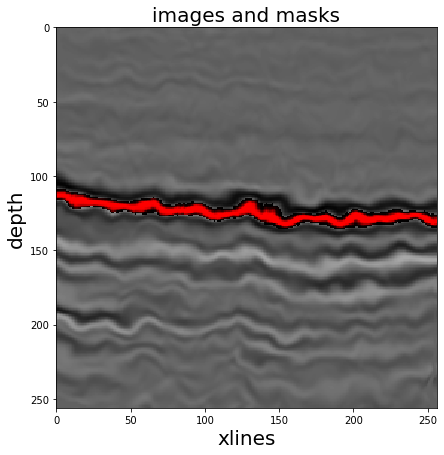

In [17]:
print(f'images: {(type(images), images.dtype, images.shape)}')
print(f'masks:  {(type(masks), masks.dtype, masks.shape)}')

plot_image((images[0, 0, ...], masks[0, 0, ...]), mode='overlap', y=1.,
           xlabel='xlines', ylabel='depth', title='images and masks')

## Convert pipeline to DataLoader

Sometimes, `PyTorch DataLoader` is convenient to use. Pipeline is already of a generative nature, so all we need to do is to wrap it into iterable dataset:

In [18]:
class PipelineDataset(IterableDataset):
    def __init__(self, pipeline, microbatch=4):
        self.pipeline = pipeline
        self.microbatch = microbatch
    
    def get_data(self):
        while True:
            batch = self.pipeline.next_batch(D('size'))
            images, masks = batch.images, batch.masks
                
            for i in range(0, len(images), self.microbatch):
                yield images[i:i+self.microbatch, ...], masks[i:i+self.microbatch, ...]

    
    def __iter__(self):
        return self.get_data()

In [19]:
%%time
pds = PipelineDataset(load_pipeline + aug_pipeline, microbatch=64)

# Note the `None` batch_size: it is already set as part of the loading pipeline
loader =  DataLoader(pds, batch_size=None, pin_memory=True)

for batch, _ in tqdm(zip(loader, range(ITERS)), total=ITERS):
    images, masks = batch

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]

CPU times: user 1min 25s, sys: 298 ms, total: 1min 26s
Wall time: 56.7 s


In [20]:
print(f'images: {(type(images), images.dtype, images.shape)}')
print(f'masks:  {(type(masks), masks.dtype, masks.shape)}')

images: (<class 'torch.Tensor'>, torch.float32, torch.Size([64, 1, 256, 256]))
masks:  (<class 'torch.Tensor'>, torch.float32, torch.Size([64, 1, 256, 256]))


`DataLoader` converts all the data from regular `NumPy` arrays to `Torch.Tensor`s; nevertheless, underlying data is [shared](https://pytorch.org/docs/stable/tensors.html).

<a id='profile2'></a>
# Model train profile

Most of the cells do exactly the same, yet implore model training step as well.

## Regular pipeline usage

We run one iteration of something-GPU-related to ensure warm start for all of the subsequent cells:

In [21]:
%%time
train_pipeline = load_pipeline + aug_pipeline + model_pipeline
train_pipeline.run(D.size, n_iters=1, bar=True)

100%|██████████| 1/1 [00:21<00:00, 21.87s/it]

CPU times: user 1.39 s, sys: 653 ms, total: 2.04 s
Wall time: 21.9 s


In [22]:
%%time
train_pipeline.run(D.size, n_iters=ITERS, bar=True)

100%|██████████| 100/100 [02:05<00:00,  1.25s/it]

CPU times: user 1min 51s, sys: 10.4 s, total: 2min 1s
Wall time: 2min 5s


As before, we can use `profile` flag to get more detailed information:

In [23]:
%%time
train_pipeline = load_pipeline + aug_pipeline + model_pipeline
train_pipeline.run(D.size, n_iters=ITERS, bar=True, profile=True)

100%|██████████| 100/100 [03:11<00:00,  1.92s/it]

CPU times: user 3min 1s, sys: 10.1 s, total: 3min 11s
Wall time: 3min 11s


In [24]:
result = train_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result['pipeline_time']

Total time of actions running:  131.65690159797668


,sum,mean,max
action,,,
train_model #13,68.773222,0.687732,0.763313
elastic_transform #10,16.141017,0.161410,0.193697
additive_noise #7,7.767117,0.077671,0.109054
rotate #8,7.726725,0.077267,0.089858
scale_2d #9,7.118042,0.071180,0.079902
flip #6,6.688294,0.066883,0.098618
load_cubes #2,3.786855,0.037869,0.051936
create_masks #1,1.742508,0.017425,0.024926
crop #0,1.614001,0.016140,0.029820


Note that this does not allow to profile individual GPU operations. You can this option in model configuration, in `train` method call or directly into the config of already existing model:

In [25]:
%%time
model.full_config['profile'] = True
train_pipeline.run(D.size, n_iters=ITERS, bar=True)
model.full_config['profile'] = False

100%|██████████| 100/100 [11:19<00:00,  6.80s/it]

CPU times: user 3min 24s, sys: 19 s, total: 3min 43s
Wall time: 11min 19s


As you can see, it takes a lot of time, though allows us to granularly inspect every cuda kernel time taken:

In [26]:
model.show_profile_info()

ncalls             CUDA_cumtime            \
                                    sum  mean   max          sum      mean   
name                                                                         
batch_norm                        57600   576   576   107.920341  1.079203   
_batch_norm_impl_index            57600   576   576    97.526260  0.975263   
conv2d                            52800   528   528    67.190412  0.671904   
contiguous                       398400  3984  3984    53.219292  0.532193   
convolution                       52800   528   528    53.015615  0.530156   
CudnnConvolutionBackward          52800   528   528    52.838190  0.528382   
torch::autograd::AccumulateGrad  168000  1680  1680    50.980660  0.509807   
_convolution                      52800   528   528    42.327180  0.423272   
CudnnBatchNormBackward            57600   576   576    38.515362  0.385154   
cudnn_convolution_backward        52800   528   528    33.644023  0.336440   

                                          CUDA_cumtime_avg                      
                                      max              sum      mean       max  
name                                                                            
batch_norm                       3.831171         0.187362  0.001874  0.006651  
_batch_norm_impl_index           3.827754         0.169316  0.001693  0.006645  
conv2d                           4.567741         0.127255  0.001273  0.008651  
contiguous                       2.821949         0.013358  0.000134  0.000708  
convolution                      3.303896         0.100408  0.001004  0.006257  
CudnnConvolutionBackward         2.807502         0.100072  0.001001  0.005317  
torch::autograd::AccumulateGrad  3.127244         0.030346  0.000303  0.001861  
_convolution                     3.301414         0.080165  0.000802  0.006253  
CudnnBatchNormBackward           2.637105         0.066867  0.000669  0.004578  
cudnn_convolution_backward       1.637412         0.063720  0.000637  0.003101

## Pipeline as data generator

That is roughly the same as what goes under the hood of `model_train` action of `Pipeline`:

In [27]:
%%time
data_pipeline = load_pipeline + aug_pipeline

for batch in tqdm(data_pipeline.gen_batch(D.size, n_iters=ITERS), total=ITERS):
    images, masks = batch.images, batch.masks
    model.train(fetches='loss', images=images, masks=masks)

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]

CPU times: user 1min 52s, sys: 11.5 s, total: 2min 3s
Wall time: 2min 3s


## Convert pipeline to DataLoader; use Lightning to train the model

Obviously, behind our `PyTorch` wrapper lies a plain old `PyTorch` model, that can be accessed via `model` attribute. There are also other attributes to store loss function, optimizer, etc. The `Lightning` wrapper just simply borrows them from our model:

In [28]:
class LightningModel(LightningModule):
    def __init__(self, bf_model, pipeline=None):
        super().__init__()
        self.bf_model = bf_model
        self.pipeline = pipeline
        
        self.loss_list = []
        
    def forward(self, x):
        return self.bf_model.model(x)
    
    def configure_optimizers(self):
        return self.bf_model.train_steps['']['optimizer']
    
    def training_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self(images)
        
        loss_func = self.bf_model.train_steps['']['loss'][0]
        loss = loss_func(predictions, targets)
        
        self.loss_list.append(loss.detach().cpu().numpy())
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def train_dataloader(self):
        if self.pipeline is not None:
            pds = PipelineDataset(self.pipeline,
                                  microbatch=self.bf_model.config.get('microbatch'))
            return DataLoader(pds, batch_size=None, pin_memory=True)

In [29]:
%%time
l_model = LightningModel(bf_model=model, pipeline=(load_pipeline + aug_pipeline) << dataset)

trainer = Trainer(gpus=1,
                  accumulate_grad_batches=16,    # reverse microbatch
                  max_steps=ITERS,               # number of iterations
                  weights_summary=None)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


CPU times: user 2.11 ms, sys: 4.15 ms, total: 6.26 ms
Wall time: 5.17 ms


In [30]:
%%time
# Total iterations number is 800 = 16 * 100 = accumulated batches * ITERS 
trainer.fit(model=l_model)


CPU times: user 8min 32s, sys: 13.4 s, total: 8min 45s
Wall time: 2min 27s


1

<a id='inference'></a>
# Inference profile

During training we were sampling points along some sparce carcass: that procedure heavily benefits of caching mechanisms in our framework: we need to load very few slices of data during the whole process, so they are instantly loaded into cache and the cube is never touched again.

During inference the whole dynamic changes: we are moving from slice to slice sequentially, so each slide is used multiple times (and cache still works wonders), but the overall amount of cube access increases dramatically. Making more overlapping predictions (contolled by the `stride` argument of `make_grid`) benefits more from caching.

Action `assemble_crops` is not like the others: it is performed only once, at the end of pipeline run. Specifically:

- pipeline iterates over crops, cut from the cube in order to cover the required volume
- for each crop, it makes a prediction with trained neural network
- after all predictions are available, `assemble_crop` creates a huge 3D array from them, taking overlapping crops into account

In [31]:
inference_pipeline = (
    Pipeline()
    # Initialize everything
    .init_variable('result_preds', [])
    .import_model(model, name='model')

    # Load data
    .crop(points=D('grid_gen')(),
          shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src='images', shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=V('result_preds', mode='e'))
    .assemble_crops(src=V('result_preds'),
                    dst='assembled_pred',
                    grid_info=D('grid_info'),
                    order=(0, 1, 2))
) << dataset

In [32]:
dataset.make_grid(dataset.indices[0], CROP_SHAPE,
                  [0, 417], [0, 868], [800, 1000],
                  strides=(1, 96, 96),
                  batch_size=BATCH_SIZE*2)


for _ in tqdm(range(dataset.grid_iters)):
    batch = inference_pipeline.next_batch(D('size'), profile=True)

100%|██████████| 79/79 [01:08<00:00,  1.16it/s]


In [33]:
result = inference_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result['pipeline_time']

Total time of actions running:  58.05370855331421


,sum,mean,max
action,,,
predict_model #5,31.330827,0.396593,2.834898
load_cubes #2,14.693117,0.185989,0.253188
assemble_crops #6,6.525909,0.082606,6.507661
scale #4,1.718591,0.021754,0.027014
adaptive_reshape #3,1.215921,0.015391,0.019784
crop #1,0.445411,0.005638,0.007325
import_model #0,0.002666,0.000034,0.000047


There is no use for the created 3D array: we need an actual 2D surface. That is done via `from_mask` staticmethod of `Horizon` class:

In [34]:
%%prun -l 10
horizons = Horizon.from_mask(batch.assembled_pred, dataset.grid_info,
                             minsize=50, threshold=0.5)

         531946 function calls (496522 primitive calls) in 1.887 seconds

   Ordered by: internal time
   List reduced from 1836 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.788    0.788    0.788    0.788 {skimage.measure._ccomp.label_cython}
      484    0.213    0.000    0.213    0.000 ffi.py:112(__call__)
        1    0.210    0.210    0.210    0.210 {built-in method scipy.ndimage._nd_image.find_objects}
        1    0.085    0.085    1.885    1.885 horizon.py:649(from_mask)
        1    0.078    0.078    0.078    0.078 {method 'nonzero' of 'numpy.ndarray' objects}
        3    0.070    0.023    0.070    0.023 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.040    0.040    0.040    0.040 utils.py:395(groupby_mean)
        1    0.017    0.017    0.017    0.017 horizon.py:699(<listcomp>)
    99762    0.016    0.000    0.027    0.000 {built-in method builtins.isinstance}
  290/288    0.014    0.000    0.

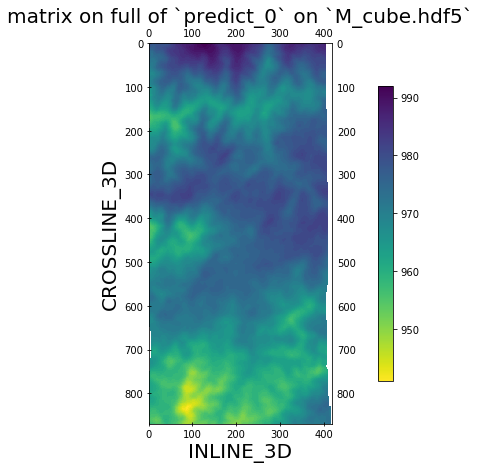

In [35]:
horizons[-1].show()

<a id='conclusion'></a>
# Conclusion

We presented detailed benchmarks for various parts of **seismiQB**, as well as showcased multiple interfaces to do data loading and model training. The timings of each approach are roughly the same, so the real difference is API.

This notebook is assumed to be run from time to time to monitor progress and speed-ups with following table to log them:

| date, DD.MM.YYYY | load + augmentations, s | load + augmentations + train, s | inference, s |
| --- | --- | --- | --- |
| 01.06.2019 | ~1600 | ~3600 | ~10000 |
| 01.06.2020 | 50 | 115 | 55 |